In [25]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from time import time

# Loda data

In [26]:
batch_size = 26
resize = (299,299)

# Load Data

data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(max(resize)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),

        'val': transforms.Compose([
            #Higher scale-up for inception
            transforms.Resize(int(max(resize)/224*256)),
            transforms.CenterCrop(max(resize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

class ImageFolderWithName(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        name = os.path.basename(path)
        return image, target, name

data_dir = os.getcwd() + '/data/LocalDataset'
datasets = {x: ImageFolderWithName(os.path.join(data_dir, x), data_transforms[x])
            for x in ['train', 'val']}
loaders = {x: DataLoader(datasets[x], 
                         batch_size=batch_size, 
                         shuffle=True) for x in ['train', 'val']}
sizes = {x: len(datasets[x]) for x in ['train', 'val']}
train_loader, test_loader = loaders['train'], loaders['val']

assert datasets['train'].classes == datasets['val'].classes
dset_classes = datasets['train'].classes
dset_classes

['Air Defense',
 'BMD',
 'BMP',
 'BTR',
 'MT_LB',
 'Self Propelled Artillery',
 'Tank']

# Model

In [29]:
class InceptionModel(nn.Module):
    def __init__(self):
        super(InceptionModel, self).__init__()
        self.inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)
        num_features = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_features, 24)

    def forward(self, x):
        x = self.inception(x)
        return x

model = InceptionModel()

device = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

# Train

In [30]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(params=model.parameters(), 
                       lr=lr)
scheduler_step_size = 7
scheduler_gamma = 0.1
scheduler = StepLR(optimizer=optimizer, 
                   step_size=scheduler_step_size, 
                   gamma=scheduler_gamma)
train_loss = []
train_acc = []
train_precision = []
train_recall = []
prediction = []
ground_truth = []
model.to(device)

num_epochs = 25

for epoch in range(num_epochs):
    t1 = time()
    running_loss = 0.0
    prediction = []
    ground_truth = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs[0], labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs[0], 1)
        ground_truth += labels.tolist()
        prediction += predicted.tolist()

    print(f'Epoch {epoch + 1}/{num_epochs} done in {time() - t1} sec, '
          f'\nloss: {round(running_loss / len(train_loader),3)}')
    true_labels = np.array(ground_truth)
    predicted_labels = np.array(prediction)
    acc = accuracy_score(true_labels, predicted_labels)
    print(f'accuracy: {acc}')
    train_acc.append(acc)
    train_loss.append(running_loss / len(train_loader))
    scheduler.step()
    print()

np.save('train_acc.npy', train_acc)
np.save('train_loss.npy', train_loss)

Epoch 1 done in 20.99315595626831 sec, 
loss: 1.509
accuracy: 0.45925925925925926
Epoch 2 done in 19.60509204864502 sec, 
loss: 1.287
accuracy: 0.5419753086419753
Epoch 3 done in 19.647149085998535 sec, 
loss: 1.144
accuracy: 0.5962962962962963
Epoch 4 done in 18.96397113800049 sec, 
loss: 1.014
accuracy: 0.6518518518518519
Epoch 5 done in 18.41010618209839 sec, 
loss: 0.922
accuracy: 0.6802469135802469
Epoch 6 done in 18.54065704345703 sec, 
loss: 0.837
accuracy: 0.7061728395061728
Epoch 7 done in 18.52857780456543 sec, 
loss: 0.847
accuracy: 0.7222222222222222
Epoch 8 done in 18.45171594619751 sec, 
loss: 0.671
accuracy: 0.7777777777777778
Epoch 9 done in 18.177045106887817 sec, 
loss: 0.524
accuracy: 0.8345679012345679
Epoch 10 done in 18.31115436553955 sec, 
loss: 0.527
accuracy: 0.8160493827160494
Epoch 11 done in 18.809476852416992 sec, 
loss: 0.435
accuracy: 0.8580246913580247
Epoch 12 done in 508.9204680919647 sec, 
loss: 0.478
accuracy: 0.8432098765432099
Epoch 13 done in 19.0

## Train Loss

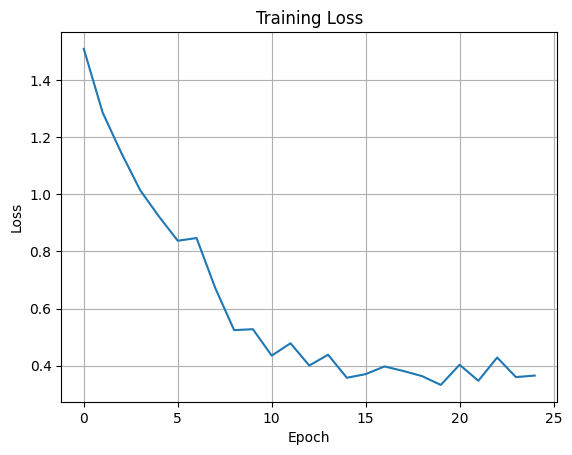

In [40]:
train_loss = np.load('train_loss.npy')

plt.plot(train_loss, label='Training Loss')
plt.grid()
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss');

## Train Accuracy

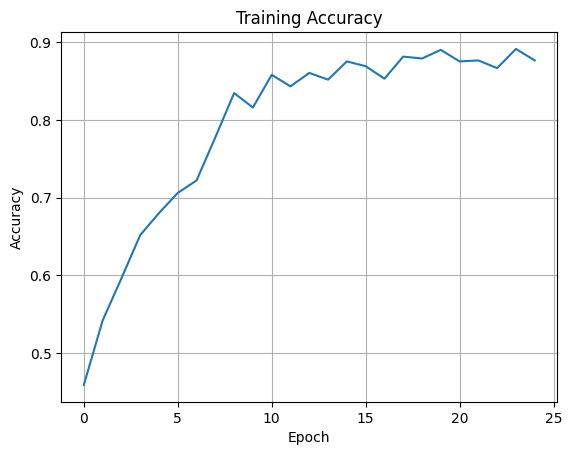

In [41]:
train_acc = np.load('train_acc.npy')

plt.plot(train_acc, label='Training Accuracy')
plt.grid()
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

# Test

In [49]:
model.eval()
correct = 0
total = 0
prediction = []
ground_truth = []
name_list = []

with torch.no_grad():
    for i, data in enumerate(test_loader):
        pred_temp = []
        truth_temp = []
        name_temp = []
        images, labels, names = data[0].to(device), data[1].to(device), data[2] 
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        ground_truth += labels.tolist()
        prediction += predicted.tolist()
        name_list += names # Collect the name values
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_temp += predicted.tolist()
        truth_temp += labels.tolist()
        name_temp += names

print(f'Accuracy of the network on {total} test images is '
      f'{round(accuracy_score(y_true=ground_truth, y_pred=prediction), 4)}')

Accuracy of the network on 236 test images is 0.8814


In [51]:
print(classification_report(ground_truth, prediction, target_names=dset_classes))

                          precision    recall  f1-score   support

             Air Defense       0.87      0.93      0.90        14
                     BMD       0.80      0.73      0.76        22
                     BMP       0.86      0.98      0.92        58
                     BTR       0.96      0.79      0.87        34
                   MT_LB       0.91      0.95      0.93        21
Self Propelled Artillery       0.90      0.69      0.78        26
                    Tank       0.88      0.93      0.90        61

                accuracy                           0.88       236
               macro avg       0.88      0.86      0.87       236
            weighted avg       0.88      0.88      0.88       236
